# [E-16] 프로젝트 - Movielens 영화 SBR

`Movielens 1M Dataset`을 기반으로 **Session based Recommendation** 시스템 제작하기

### `session`
: 일정 시간동안 같은 브라우저로부터 들어오는 일련의 요구를 하나의 상태로 보고, 그 상태를 유지하는 기술로, 웹 브라우저를 통해 웹 서버에 접속한 이후 브라우저를 종료할 때까지 유지되는 상태

- `세션ID`: 단순히 사용자를 식별할 수 있는 의미 없는 문자들로 만들어져 있다.

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

1.3.3
2.6.0


In [2]:
# 1) 데이터 확인
# $ ls -l ~/data

# 2) 프로젝트 폴더 생성
# $ mkdir -p ~/aiffel/yoochoose

# 3) 프로젝트 폴더로 데이터 폴더 링크 연결
# $ ln -s ~/data/* ~/aiffel/yoochoose/data

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

UserId  ItemId  Rating       Time
31            1    3186       4  978300019
22            1    1270       5  978300055
27            1    1721       4  978300055
37            1    1022       5  978300055
24            1    2340       3  978300103
...         ...     ...     ...        ...
1000019    6040    2917       4  997454429
999988     6040    1921       4  997454464
1000172    6040    1784       3  997454464
1000167    6040     161       3  997454486
1000042    6040    1221       4  998315055

[1000209 rows x 4 columns]

> 🥕 이 실습에선 `SessionID` 대신 `UserID`가 들어갔다.
> - 명확한 1회 세션의 SessionID를 포함하고 있지 않는다.

> 🥕 Rating 정보가 포함됨
> - 직전에 봤던 영화가 맘에 들었는지에 대한 정보가 비슷한 영화를 더 고르게 할 수도 있을 것이다.
> - Rating이 낮은 데이터를 어떻게 처리할지도 고민해본다.

> 🥕 Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있음

## 1. 데이터 전처리
- 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행하자.
- Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지 주의하자.

In [4]:
data.head()

UserId  ItemId  Rating       Time
31       1    3186       4  978300019
22       1    1270       5  978300055
27       1    1721       4  978300055
37       1    1022       5  978300055
24       1    2340       3  978300103

### UTC time 변환
- Time 항목은 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있으므로, 이를 `Datetime`으로 변환해보자.
> [참조 블로그1](https://www.44bits.io/ko/post/python-datatime-cheetsheet), [참조 블로그2](https://journeytosth.tistory.com/29)

In [5]:
import datetime as dt

now = 978300019
time = dt.datetime.utcfromtimestamp(now)
print(time)

2000-12-31 22:00:19


In [6]:
utc_to_datetime = []

for time in data["Time"]:
    time_new = dt.datetime.utcfromtimestamp(time)
    utc_to_datetime.append(time_new)

In [7]:
data['Time'] = utc_to_datetime
data['Time']

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [8]:
data.head()

UserId  ItemId  Rating                Time
31       1    3186       4 2000-12-31 22:00:19
22       1    1270       5 2000-12-31 22:00:55
27       1    1721       4 2000-12-31 22:00:55
37       1    1022       5 2000-12-31 22:00:55
24       1    2340       3 2000-12-31 22:01:43

### Session Length
- 각 UserId의 분포

In [9]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [10]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

> `session_length`: `SessionId`를 공유하는 데이터 row의 개수를 의미하며 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지를 나타낸다.
> - 여기선 `SessionId` 대신 `UserId`가 들어왔다.
> - 따라서 이를 Session 단위로 어떻게 해석할지 고려해봐야 할 것

In [11]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [12]:
session_length.min(), session_length.max()

(20, 2314)

In [13]:
session_length.quantile(0.999)

1343.181000000005

> session_length의 99.9%가 약 1343 인데, 길이가 2314인 세션은 무엇일지 알아보자.

In [14]:
# 길이가 2314인 session들
long_session = session_length[session_length==2314].index[0]
data[data['UserId'] == long_session]

UserId  ItemId  Rating                Time
696969    4169    1268       5 2000-08-03 20:09:52
697168    4169    2617       4 2000-08-03 20:09:52
697185    4169    2628       4 2000-08-03 20:09:52
697219    4169    2653       4 2000-08-03 20:09:52
697275    4169     423       3 2000-08-03 20:09:52
...        ...     ...     ...                 ...
697882    4169    3754       2 2002-06-15 20:52:27
695702    4169    1413       3 2002-06-15 21:03:51
697358    4169     494       4 2002-06-15 21:16:00
695945    4169    1804       2 2002-06-15 21:16:23
696446    4169    1548       3 2002-06-15 21:25:37

[2314 rows x 4 columns]

In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum() # cumsum(): 누적합
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

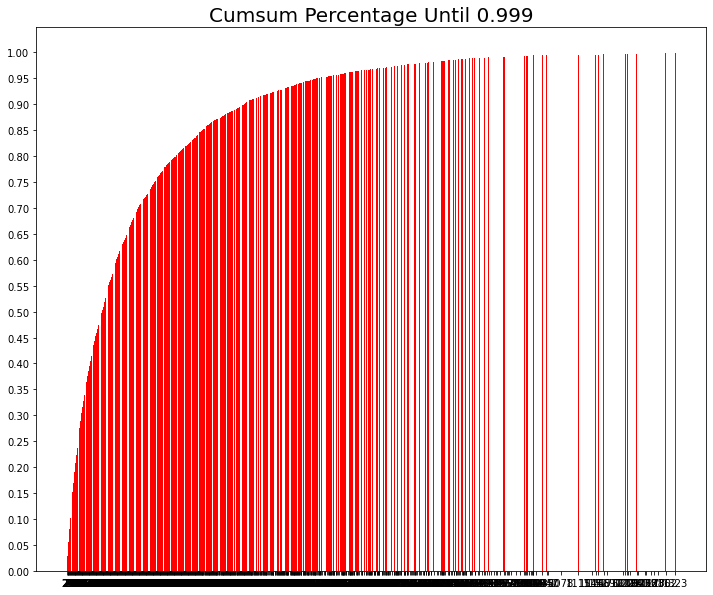

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time
- 최근 시청 영화 트랜드 확인

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


> 약 3년 정도의 데이터가 있다.

### - Session Id 생성

In [18]:
data.head()

UserId  ItemId  Rating                Time
31       1    3186       4 2000-12-31 22:00:19
22       1    1270       5 2000-12-31 22:00:55
27       1    1721       4 2000-12-31 22:00:55
37       1    1022       5 2000-12-31 22:00:55
24       1    2340       3 2000-12-31 22:01:43

이 예제에는 SessionId가 아닌 UserId를 이용했다.
- 한 User가 여러 개의 세션을 만들 수 있으므로 이 예제에서 `UserId`는 실습에서 다룬 `SessionId`가 여러 개 들어간 값일 것이다.
> 그렇다면 여기서 SessionId를 새로 생성할 수 있을까? `UserId`로부터 `SessionId`를 어떻게 만들 수 있을까.
> - 같은 `UserId`를 가지는 데이터의 `Time` 값이 같다면 이는 동일한 session을 갖는다는 말로 이해했다. 그렇다면 이 경우에 같은 `SessionId`를 만들어 새로운 열로 저장하자!

In [19]:
# 예를 들어 UserId==1인 경우 sessionid 판단해보기

data[data["UserId"] == 1]

UserId  ItemId  Rating                Time
31       1    3186       4 2000-12-31 22:00:19
22       1    1270       5 2000-12-31 22:00:55
27       1    1721       4 2000-12-31 22:00:55
37       1    1022       5 2000-12-31 22:00:55
24       1    2340       3 2000-12-31 22:01:43
36       1    1836       5 2000-12-31 22:02:52
3        1    3408       4 2000-12-31 22:04:35
7        1    2804       5 2000-12-31 22:11:59
47       1    1207       4 2000-12-31 22:11:59
0        1    1193       5 2000-12-31 22:12:40
21       1     720       3 2000-12-31 22:12:40
44       1     260       4 2000-12-31 22:12:40
9        1     919       4 2000-12-31 22:22:48
51       1     608       4 2000-12-31 22:23:18
43       1    2692       4 2000-12-31 22:26:10
41       1    1961       5 2000-12-31 22:26:30
48       1    2028       5 2000-12-31 22:26:59
18       1    3105       5 2000-12-31 22:28:33
11       1     938       4 2000-12-31 22:29:12
14       1    1035       5 2000-12-31 22:29:13
42       1    1962       4 2000-12-31 22:29:13
17       1    2018       4 2000-12-31 22:29:37
39       1     150       5 2000-12-31 22:29:37
45       1    1028       5 2000-12-31 22:29:37
26       1    1097       4 2000-12-31 22:32:33
2        1     914       3 2000-12-31 22:32:48
6        1    1287       5 2000-12-31 22:33:59
19       1    2797       4 2000-12-31 22:33:59
38       1    2762       4 2000-12-31 22:34:51
52       1    1246       4 2000-12-31 22:34:51
1        1     661       3 2000-12-31 22:35:09
13       1    2918       4 2000-12-31 22:35:24
49       1     531       4 2000-12-31 22:35:49
50       1    3114       4 2000-12-31 22:36:14
15       1    2791       4 2000-12-31 22:36:28
20       1    2321       3 2000-12-31 22:36:45
46       1    1029       5 2000-12-31 22:36:45
5        1    1197       3 2000-12-31 22:37:48
8        1     594       4 2000-12-31 22:37:48
12       1    2398       4 2000-12-31 22:38:01
28       1    1545       4 2001-01-06 23:35:39
23       1     527       5 2001-01-06 23:36:35
10       1     595       5 2001-01-06 23:37:48
16       1    2687       3 2001-01-06 23:37:48
29       1     745       3 2001-01-06 23:37:48
33       1     588       4 2001-01-06 23:37:48
40       1       1       5 2001-01-06 23:37:48
4        1    2355       5 2001-01-06 23:38:11
30       1    2294       4 2001-01-06 23:38:11
35       1     783       4 2001-01-06 23:38:11
32       1    1566       4 2001-01-06 23:38:50
34       1    1907       4 2001-01-06 23:38:50
25       1      48       5 2001-01-06 23:39:11

위 index `22, 27, 37`을 보면 UserId가 1인 경우 Time이 동일한 것을 확인할 수 있다.
- 이런 데이터들에 같은 `SessionId`를 부여하자.

<br/>

> 같은 `UserId`와 `Time`을 갖는 데이터들을 판별하기 위해 `groupby`로 묶자.
> - 2개의 기준으로 묶기 위해선 안에 리스트로 묶어주기

In [20]:
# 이런식으로 묶을 수 있다.
# 'ItemId'은 그냥 개수를 세기 위해 추가한 열 (Rating으로 개수 세도 된다.)
# UserId 컬럼 열로 따로 빼기 위해 reset_index() 취함
pd.DataFrame(data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index())

UserId                Time  ItemId
0            1 2000-12-31 22:00:19       1
1            1 2000-12-31 22:00:55       3
2            1 2000-12-31 22:01:43       1
3            1 2000-12-31 22:02:52       1
4            1 2000-12-31 22:04:35       1
...        ...                 ...     ...
471158    6040 2001-08-10 14:39:58       1
471159    6040 2001-08-10 14:40:29       1
471160    6040 2001-08-10 14:41:04       2
471161    6040 2001-08-10 14:41:26       1
471162    6040 2001-08-20 13:44:15       1

[471163 rows x 3 columns]

In [21]:
# 위 방법 그대로 새로운 데이터프레임 new_data 생성
# 압축된(?) 데이터프레임
new_data = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
new_data.reset_index(inplace=True) # index 따로 추출하기 위해 reset_index() -> 나중에 SessionId에 도움이 될 것
new_data

index  UserId                Time  ItemId
0            0       1 2000-12-31 22:00:19       1
1            1       1 2000-12-31 22:00:55       3
2            2       1 2000-12-31 22:01:43       1
3            3       1 2000-12-31 22:02:52       1
4            4       1 2000-12-31 22:04:35       1
...        ...     ...                 ...     ...
471158  471158    6040 2001-08-10 14:39:58       1
471159  471159    6040 2001-08-10 14:40:29       1
471160  471160    6040 2001-08-10 14:41:04       2
471161  471161    6040 2001-08-10 14:41:26       1
471162  471162    6040 2001-08-20 13:44:15       1

[471163 rows x 4 columns]

In [22]:
# new_data와 data 비교해보기
data

UserId  ItemId  Rating                Time
31            1    3186       4 2000-12-31 22:00:19
22            1    1270       5 2000-12-31 22:00:55
27            1    1721       4 2000-12-31 22:00:55
37            1    1022       5 2000-12-31 22:00:55
24            1    2340       3 2000-12-31 22:01:43
...         ...     ...     ...                 ...
1000019    6040    2917       4 2001-08-10 14:40:29
999988     6040    1921       4 2001-08-10 14:41:04
1000172    6040    1784       3 2001-08-10 14:41:04
1000167    6040     161       3 2001-08-10 14:41:26
1000042    6040    1221       4 2001-08-20 13:44:15

[1000209 rows x 4 columns]

In [23]:
# data와 new_data를 UserId와 Time을 기준으로 합친다.
# ItemId 열이 2개가 생겨 각각 자동으로 ItemId_x와 ItemId_y로 이름이 생긴다.

data = pd.merge(data, new_data, on=["UserId", "Time"])
data

UserId  ItemId_x  Rating                Time   index  ItemId_y
0             1      3186       4 2000-12-31 22:00:19       0         1
1             1      1270       5 2000-12-31 22:00:55       1         3
2             1      1721       4 2000-12-31 22:00:55       1         3
3             1      1022       5 2000-12-31 22:00:55       1         3
4             1      2340       3 2000-12-31 22:01:43       2         1
...         ...       ...     ...                 ...     ...       ...
1000204    6040      2917       4 2001-08-10 14:40:29  471159         1
1000205    6040      1921       4 2001-08-10 14:41:04  471160         2
1000206    6040      1784       3 2001-08-10 14:41:04  471160         2
1000207    6040       161       3 2001-08-10 14:41:26  471161         1
1000208    6040      1221       4 2001-08-20 13:44:15  471162         1

[1000209 rows x 6 columns]

> 여기서 `index`가 바로 `SessioinId`가 될 것이다.
> - 잘 보면 UserId와 Time이 모두 동일한 2, 3, 4번째 행의 데이터들의 index가 같게 출력이 된다.

> - 이제 `ItemId_y`의 열은 필요 없으므로 지워주고,
> - `index` 열은 `SessionId`로 이름을 변경해주고,
> - `ItemId_x` 열은 이름을 다시 `ItemId`로 변경해주자.

In [24]:
# 필요 없는 열 삭제
data.drop(["ItemId_y"], axis=1, inplace=True)
data.head()

UserId  ItemId_x  Rating                Time  index
0       1      3186       4 2000-12-31 22:00:19      0
1       1      1270       5 2000-12-31 22:00:55      1
2       1      1721       4 2000-12-31 22:00:55      1
3       1      1022       5 2000-12-31 22:00:55      1
4       1      2340       3 2000-12-31 22:01:43      2

In [25]:
# 열 이름 변경
data.rename(columns={'index': 'SessionId', 'ItemId_x': 'ItemId'}, inplace=True)
data.head()

UserId  ItemId  Rating                Time  SessionId
0       1    3186       4 2000-12-31 22:00:19          0
1       1    1270       5 2000-12-31 22:00:55          1
2       1    1721       4 2000-12-31 22:00:55          1
3       1    1022       5 2000-12-31 22:00:55          1
4       1    2340       3 2000-12-31 22:01:43          2

In [26]:
len(data)

1000209

### - New Session Length

In [27]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [28]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [29]:
session_length.min(), session_length.max()

(1, 30)

In [30]:
session_length.quantile(0.999)

10.0

> - 한 세션에 평균 2개의 영화를 보는데 최댓값은 28
> - 99.9%가 10개 이하의 영화를 보기 때문에 28은 이상치일 수 있다고 판단

In [31]:
session_length[session_length==28].index[0]

55112

In [32]:
# 길이가 28 session들
long_session = session_length[session_length==28].index[0]
data[data['SessionId'] == long_session]

UserId  ItemId  Rating                Time  SessionId
112250     731    2054       4 2000-11-29 19:56:21      55112
112251     731       2       5 2000-11-29 19:56:21      55112
112252     731    2087       5 2000-11-29 19:56:21      55112
112253     731     788       4 2000-11-29 19:56:21      55112
112254     731    1654       5 2000-11-29 19:56:21      55112
112255     731     247       4 2000-11-29 19:56:21      55112
112256     731     260       3 2000-11-29 19:56:21      55112
112257     731    2100       5 2000-11-29 19:56:21      55112
112258     731    2105       4 2000-11-29 19:56:21      55112
112259     731     653       4 2000-11-29 19:56:21      55112
112260     731    2140       4 2000-11-29 19:56:21      55112
112261     731    2161       4 2000-11-29 19:56:21      55112
112262     731    2173       4 2000-11-29 19:56:21      55112
112263     731    2174       5 2000-11-29 19:56:21      55112
112264     731    2193       4 2000-11-29 19:56:21      55112
112265     731    1920       4 2000-11-29 19:56:21      55112
112266     731    1009       4 2000-11-29 19:56:21      55112
112267     731    1967       4 2000-11-29 19:56:21      55112
112268     731     367       4 2000-11-29 19:56:21      55112
112269     731    2797       4 2000-11-29 19:56:21      55112
112270     731      60       3 2000-11-29 19:56:21      55112
112271     731    2005       4 2000-11-29 19:56:21      55112
112272     731    2015       4 2000-11-29 19:56:21      55112
112273     731    2017       3 2000-11-29 19:56:21      55112
112274     731    1073       3 2000-11-29 19:56:21      55112
112275     731    2021       4 2000-11-29 19:56:21      55112
112276     731    1097       5 2000-11-29 19:56:21      55112
112277     731    2043       3 2000-11-29 19:56:21      55112

In [33]:
# 이 값은 제외하자.

data = data[data['SessionId'] != long_session]
data

UserId  ItemId  Rating                Time  SessionId
0             1    3186       4 2000-12-31 22:00:19          0
1             1    1270       5 2000-12-31 22:00:55          1
2             1    1721       4 2000-12-31 22:00:55          1
3             1    1022       5 2000-12-31 22:00:55          1
4             1    2340       3 2000-12-31 22:01:43          2
...         ...     ...     ...                 ...        ...
1000204    6040    2917       4 2001-08-10 14:40:29     471159
1000205    6040    1921       4 2001-08-10 14:41:04     471160
1000206    6040    1784       3 2001-08-10 14:41:04     471160
1000207    6040     161       3 2001-08-10 14:41:26     471161
1000208    6040    1221       4 2001-08-20 13:44:15     471162

[1000181 rows x 5 columns]

In [34]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum() # cumsum(): 누적합
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

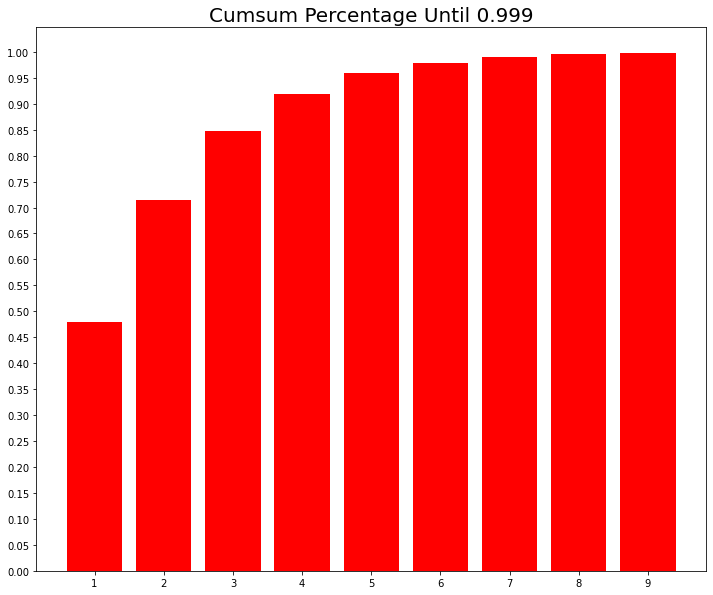

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Data Cleansing
### - Session Rating
- 직전에 봤던 영화가 맘에 들었는지 여부가 영화 추천에 도움이 될 수도 있을 것이다.
- Rating이 낮은 데이터 어떻게 처리할지 고민하기

In [36]:
data.head()
print(len(data))

1000181


<AxesSubplot:xlabel='Rating', ylabel='Density'>

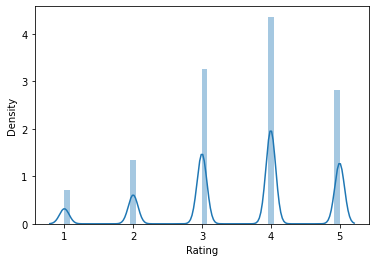

In [37]:
import seaborn as sns

sns.distplot(data["Rating"])

In [38]:
data.groupby("Rating").size()

Rating
1     56174
2    107557
3    261192
4    348954
5    226304
dtype: int64

> Rating으로 그룹화한 결과, `3, 4, 5`보다 `1, 2`의 분포가 적은 것을 확인할 수 있다.
> - 이렇게 Rating이 낮은 데이터는 제외하자!

In [39]:
data = data[data["Rating"] >= 3]
print(len(data))

836450


In [40]:
data

UserId  ItemId  Rating                Time  SessionId
0             1    3186       4 2000-12-31 22:00:19          0
1             1    1270       5 2000-12-31 22:00:55          1
2             1    1721       4 2000-12-31 22:00:55          1
3             1    1022       5 2000-12-31 22:00:55          1
4             1    2340       3 2000-12-31 22:01:43          2
...         ...     ...     ...                 ...        ...
1000204    6040    2917       4 2001-08-10 14:40:29     471159
1000205    6040    1921       4 2001-08-10 14:41:04     471160
1000206    6040    1784       3 2001-08-10 14:41:04     471160
1000207    6040     161       3 2001-08-10 14:41:26     471161
1000208    6040    1221       4 2001-08-20 13:44:15     471162

[836450 rows x 5 columns]

## 2. 미니 배치의 구성
데이터셋과 미니 배치를 구성해보기
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성하자.
- 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라 Session-Parallel Mini-Batch가 굳이 필요하지 않을 수도 있다.

### Train / Valid / Test 셋 분리하기

In [41]:
# 여러 전처리, cleansing 과정을 거치니 위에서 생성한 oldest, latest와 값이 달라졌음을 확인
# (+) 시간(초)만 달라졌다!

print(data["Time"].min())
print(data["Time"].max())

2000-04-25 23:05:32
2003-02-28 17:49:50


> 약 3년의 데이터를 어떤 기준으로 나누면 좋을까.
> - 총 약 36개월의 데이터가 존재.
> - 실습 데이터에서 한 달(30일 기준)을 28일/2일로 나누었으니, 36/15=2.4, 약 3개월을 val+test set으로, 나머지 33개월을 train set으로 나누자.

In [42]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    
    return before_date, after_date

In [43]:
# 3개월은 90일
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

# 수정
# tr, test = split_by_date(data, n_days=90)
# tr, val = split_by_date(tr, n_days=365)

In [44]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [45]:
# 너무 적나?! 약간 의문
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 829147
	 Sessions: 418095
	 Items: 3623
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 3546
	 Sessions: 2532
	 Items: 1549
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 3752
	 Sessions: 2776
	 Items: 1565
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [46]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [47]:
save_path = data_path / 'processed_new'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Data Pipeline

### - SessionDataset

In [48]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [49]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating                Time  SessionId  item_idx
0       1    3186       4 2000-12-31 22:00:19          0         0
1       1    1270       5 2000-12-31 22:00:55          1         1
2       1    1721       4 2000-12-31 22:00:55          1         2
3       1    1022       5 2000-12-31 22:00:55          1         3
4       1    2340       3 2000-12-31 22:01:43          2         4
5       1    1836       5 2000-12-31 22:02:52          3         5
6       1    3408       4 2000-12-31 22:04:35          4         6
7       1    2804       5 2000-12-31 22:11:59          5         7
8       1    1207       4 2000-12-31 22:11:59          5         8
9       1    1193       5 2000-12-31 22:12:40          6         9

In [50]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 829145, 829146, 829147], dtype=int32)

In [51]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 418092, 418093, 418094])

### - SessionDataLoader

In [52]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]    # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False      # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [53]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

UserId  ItemId  Rating                Time  SessionId  item_idx
0        1    3186       4 2000-12-31 22:00:19          0         0
1        1    1270       5 2000-12-31 22:00:55          1         1
2        1    1721       4 2000-12-31 22:00:55          1         2
3        1    1022       5 2000-12-31 22:00:55          1         3
4        1    2340       3 2000-12-31 22:01:43          2         4
5        1    1836       5 2000-12-31 22:02:52          3         5
6        1    3408       4 2000-12-31 22:04:35          4         6
7        1    2804       5 2000-12-31 22:11:59          5         7
8        1    1207       4 2000-12-31 22:11:59          5         8
9        1    1193       5 2000-12-31 22:12:40          6         9
10       1     720       3 2000-12-31 22:12:40          6        10
11       1     260       4 2000-12-31 22:12:40          6        11
12       1     919       4 2000-12-31 22:22:48          7        12
13       1     608       4 2000-12-31 22:23:18          8        13
14       1    2692       4 2000-12-31 22:26:10          9        14

In [54]:
iter_ex = iter(tr_data_loader)

In [55]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## 3. 모델 구성
### - Evalutaion Metric
- `MRR`과 `Recall@k`를 사용하자.

In [56]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1) # 역순
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### - Model Architecture

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [58]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    
    return model

In [59]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# 배치 사이즈 줄이기 (2048 -> 64)
# epoch 늘리기 (3->10)
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [60]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3623)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    551250    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3623)               184773    
Total params: 736,023
Trainable params: 736,023
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습

In [61]:
# train 셋으로 학습하면서 valid 셋으로 검증.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화. 아래 메서드에서 확인할 수 있음.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 함.
    gru_layer.reset_states(states=hidden_states)


# valid셋과 test셋을 평가하는 코드
def get_metrics(data, model, args, k: int): 
    
    # train과 거의 같지만 mrr, recall을 구하는 라인이 있음.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  #softmax 값이 큰 순서대로 sorting.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [62]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.64it/s]


	 - Recall@20 epoch 1: 0.115885
	 - MRR@20    epoch 1: 0.031140



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.82it/s]


	 - Recall@20 epoch 2: 0.178385
	 - MRR@20    epoch 2: 0.052804



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.86it/s]


	 - Recall@20 epoch 3: 0.194010
	 - MRR@20    epoch 3: 0.060578



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.87it/s]


	 - Recall@20 epoch 4: 0.192708
	 - MRR@20    epoch 4: 0.063418



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.87it/s]


	 - Recall@20 epoch 5: 0.195312
	 - MRR@20    epoch 5: 0.066282



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.85it/s]


	 - Recall@20 epoch 6: 0.195312
	 - MRR@20    epoch 6: 0.068214



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.90it/s]


	 - Recall@20 epoch 7: 0.188802
	 - MRR@20    epoch 7: 0.068724



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.91it/s]


	 - Recall@20 epoch 8: 0.190104
	 - MRR@20    epoch 8: 0.068554



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.86it/s]


	 - Recall@20 epoch 9: 0.196615
	 - MRR@20    epoch 9: 0.068575



Evaluation:  86%|████████▌ | 6/7 [00:03<00:00,  1.85it/s]

	 - Recall@20 epoch 10: 0.191406
	 - MRR@20    epoch 10: 0.065418



## 6. 모델 테스트

In [63]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

	 - Recall@20: 0.274554
	 - MRR@20: 0.101408



## 🐣 오류 해결 과정 및 성능 개선

### 🧤 Key Point
- `Recall@k`란 (recall의 확장 개념) 얼마나 잘 예측했냐를 나타내므로, **값이 클수록 성능이 좋다.**
- `MRR`은 정답 아이템이 추천 결과 앞쪽 순번에 나오면 지표가 높아지므로, **값이 클수록 성능이 좋다고 말할 수 있다.**

<br/>

> #### 1. `코드 실수`
> - 기껏 모델을 train 했는데 이전 예제 실습에서 다룬 모델을 받아오는 실수를 범했다 ..! 무작정 복붙하지 말기

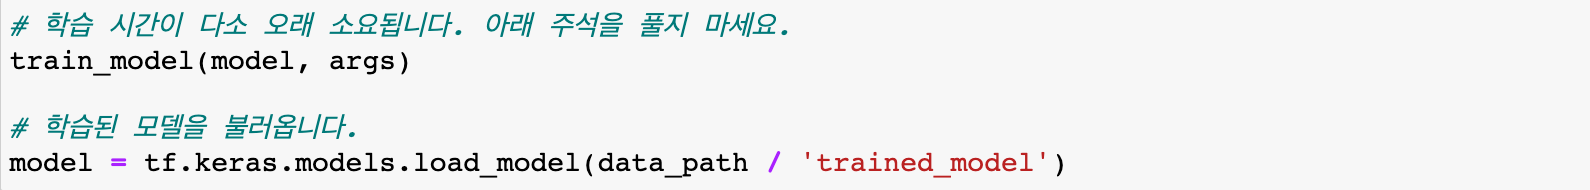
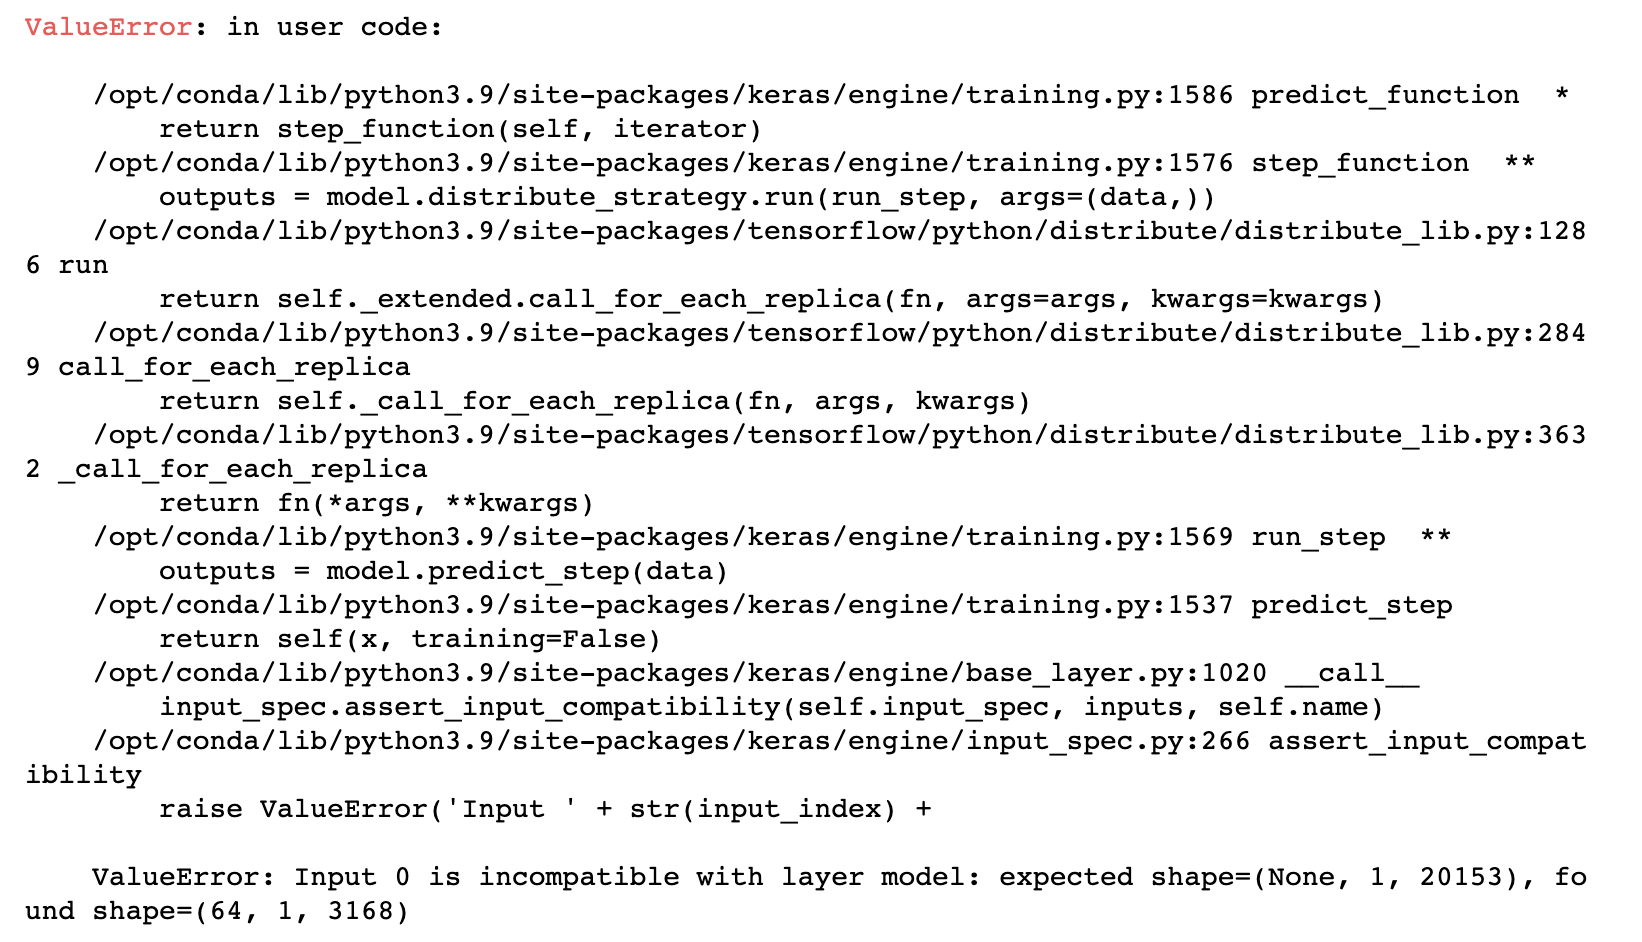

> #### 2. `batch size` 문제 -> IndexError
> - batch size를 2048로 하니 IndexError가 발생했다.

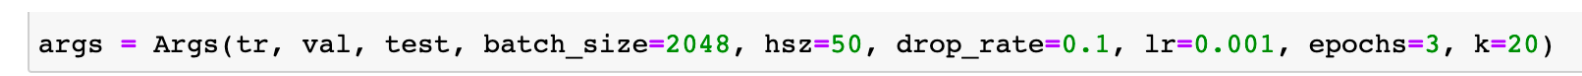
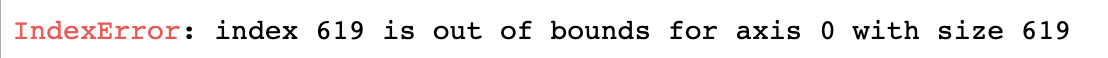

> #### 👍 3. `batch size = 64` & `batch size = 128`
> - Batch size의 크기 줄였더니 결과가 잘 나왔다.
> - Recall과 MRR만으론 두 모델 중 어느 성능이 더 좋다 판단하긴 어렵지만 평가 정확도가 batch size=128일 때 높게 나온다.

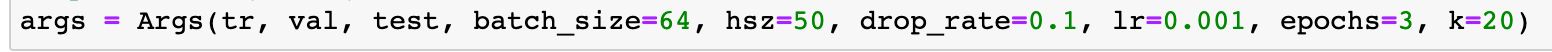
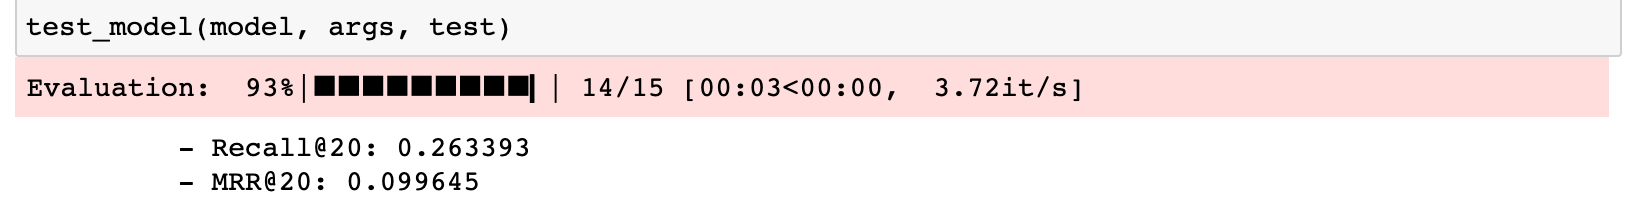

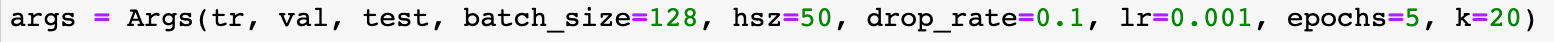
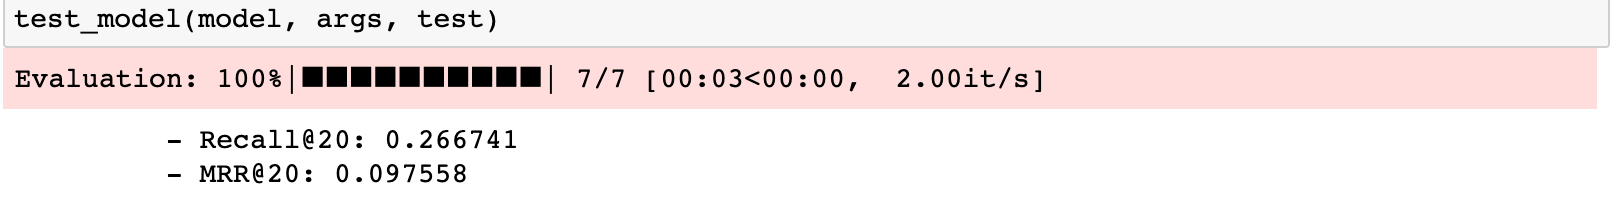

> #### 4. `learning rate = 0.01` -> 성능 하락
> - Learning Rate를 0.001에서 0.01로 증가시켰는데, Recall와 MRR은 모두 약간씩 감소해 성능이 더 좋지 않았다.

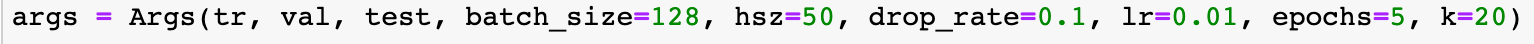
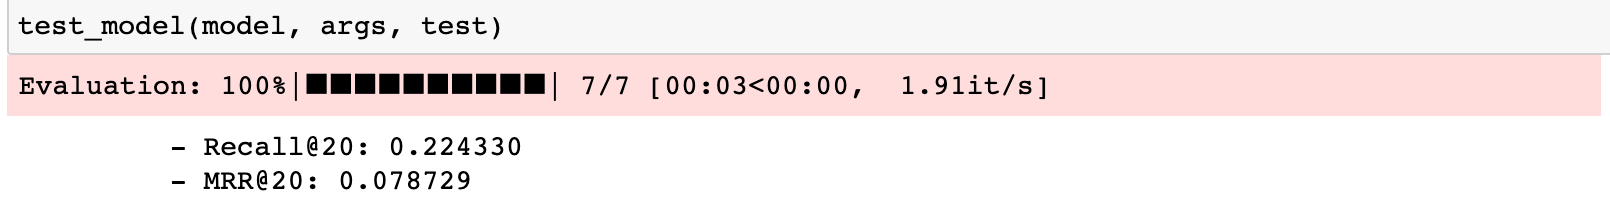

> #### 5. validation set 크기 증가 -> 성능 하락
> - validation set의 크기를 너무 작게 설정한 것 같아 90일에서 365일로 크기를 키웠지만, 성능은 약간 더 하락했다.
> - 데이터셋 크기가 크다고 꼭 좋은 것만은 아닌 것을 깨달음
> - test set 크기 변경에서도 마찬가지 결과였다.

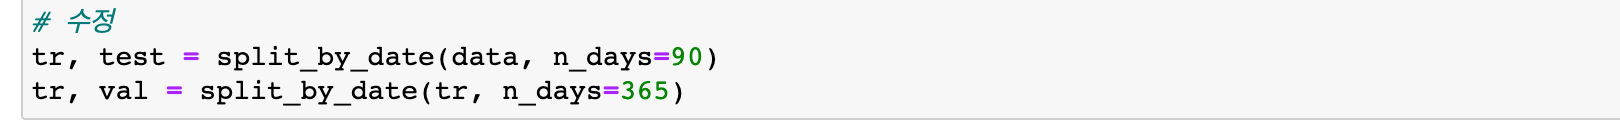

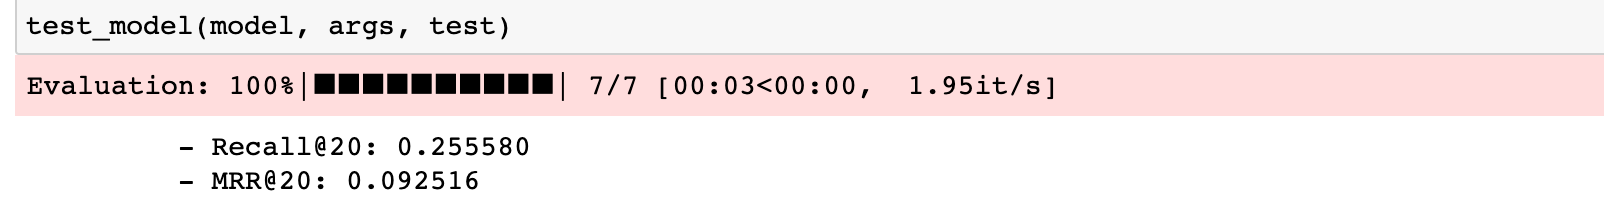

> #### 6. `Ratings >= 3` 미제거
> - 영화 평가 지표인 Rating이 3보다 작은 부분을 제거하지 않았더니 정확성이 90%로 감소했다.
> - 직전에 본 영화의 Rating이 모델의 정확성과 성능에 영향을 미친다.

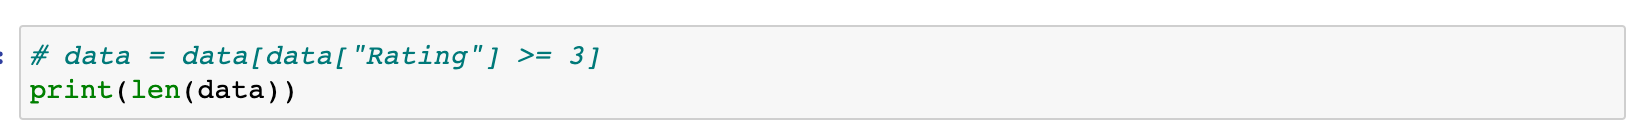
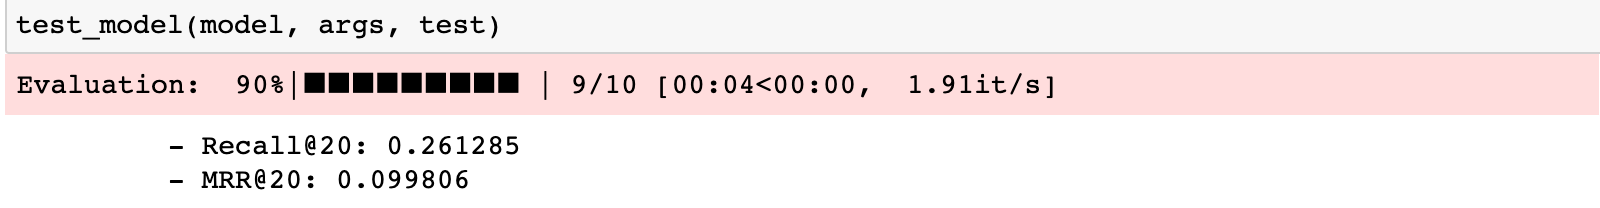

> #### 👍 7. epoch 증가
> - 최종적으로 가장 좋았던 성능인 3번의 결과에서 epoch만 10으로 증가시켰다.
> - 가장 좋은 성능을 보였다.

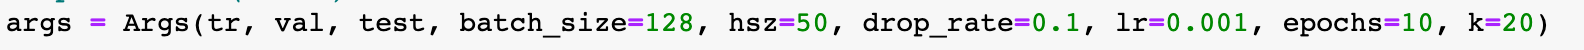
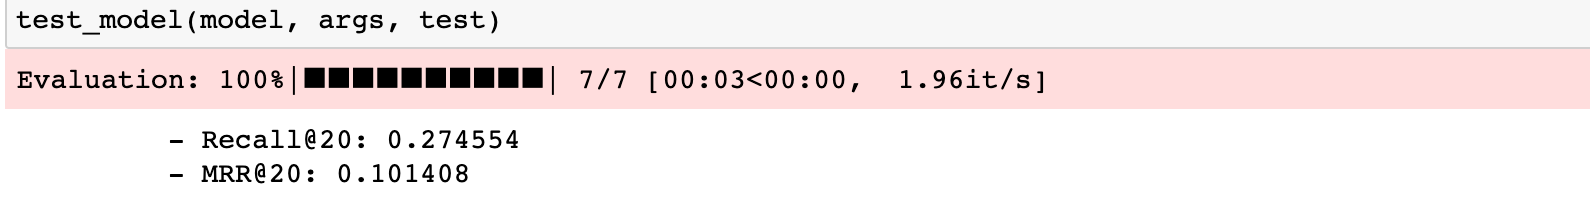

***

## 🧤 회고

- 처음 SessionId가 아닌 UserId를 받았을 때, 이를 어떻게 사용해야 할지 모르겠었다. 둘의 개념적 이해가 완벽하게 되지 않아 그냥 이름만 대체해 사용할까 고민했지만, 이는 결국 모델의 성능에도 영향을 미칠 것 같아 자세히 살펴보았다.


- 내가 이해한 바로는, Session이란 웹 브라우저에 접속해 종료할 때까지 유지되는 상태이며, Session Id는 Session에서 발생한 click 수이고, 한 세션에선 1개 or 무수히 많은 클릭들이 존재한다. 이를 integer로 나타낸 값이다.


- UserId란 말 그대로 User의 id이며 한 User가 다양한 Session을 가질 수 있으므로 당연히 다양한 Session ID를 가질 수 있다. 따라서 본 노드의 초기 UserId는 여러 SessionID를 중복해 가진다고 이해했다.


- 따라서 같은 UserId를 가진 사용자가 동일한 Time에 기록이 남았다면, 이는 같은 Session Id를 가진다 판단하였고, 이에 따라 UserId와 Time을 고려해 Session Id를 만들었다.


- 처음 IndexError가 나왔을 땐 어찌 해결해야하나 당황했는데, 다른 분들의 도움으로 batch size를 줄여 해결이 가능했다. 하지만 data에서 어떤 이유로 배치 사이즈를 2048로 설정했을 때 인덱스를 벗어나는 오류가 뜬 건지 이해하지 못해 좀 더 살펴봐야겠다.


- 모델의 성능을 높이기 위해 하이퍼파라미터 변경 작업을 많이 진행했는데 돌릴 때마다 미묘하게 달라지는 결과값을 볼 수 있었다. 어느 정도 차이가 유의미하고, 어떤 수준 이상이어야 좋다고 말할 수 있을진 모르겠지만 또 한 번 파라미터들의 능력을 체험해 볼 수 있었다.


- hsz, k의 값은 잘 이해하지 못해 변경해보지 못한 점이 아쉬웠다.


- 우리의 데이터에서 다른 사람들은 어떤 식으로 전처리를 하고 모델을 짰을지 궁금하다. 